In [1]:
# Split the data into training and test datasets. Make sure your split is
# reproducible and that it maintains roughly the proportion of each class of
# dependent variable. (1 point)
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('california_housing.csv')
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price_above_median
0,2.1827,26.0,4.521429,0.921429,305.0,2.178571,40.05,-122.10,0
1,3.0755,32.0,4.623068,0.983353,3868.0,4.599287,32.77,-117.06,0
2,1.8235,40.0,4.701149,1.126437,928.0,3.555556,37.75,-122.16,0
3,1.4625,37.0,4.247845,1.105603,1673.0,3.605603,33.99,-118.28,0
4,1.9063,13.0,3.453125,0.984375,286.0,4.468750,33.97,-118.16,0
...,...,...,...,...,...,...,...,...,...
20629,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84,1
20630,5.6790,20.0,6.401274,1.070064,457.0,2.910828,38.56,-122.05,1
20631,1.9327,10.0,5.789474,1.078947,898.0,3.938596,38.57,-121.92,1
20632,3.7500,38.0,5.275229,0.981651,259.0,2.376147,38.72,-121.90,1


In [2]:
# Split the data into training and test datasets
X = data.drop('price_above_median', axis=1)
y = data['price_above_median']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [3]:
# Perform classification using below supervised learning techniques. When
# appropriate, use a hyperparameter space search to find optimal hyperparameter
# setting. Consider using other techniques from class lectures, such as data
# standardization. At a minimum, you should try the following model algorithms:
# K-nearest neighbor, Decision Tree Classifier, Random Forest Classifier, and
# AdaBoost Classifier. (5 points)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Intuition behind the choice of scalers:
# For the features 'MedInc', 'AveRooms', 'AveBedrms', 'Population', and
# 'AveOccup', they are strongly skewed to the right and have outliers, so it
# makes sense to use RobustScaler which is less sensitive to outliers. For
# 'HouseAge', 'Latitude', and 'Longitude', they are less skewed/more centered
# and do not have extreme outliers, so StandardScaler is appropriate, even if
# 'Latitude' and 'Longitude' are multi-modal. The target needs no scaling.

# Define the feature groups based on how to scale them
robust_cols = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
standard_cols = ['HouseAge', 'Latitude', 'Longitude']

# Create a preprocessor that applies different scalers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), robust_cols),
        ('standard', StandardScaler(), standard_cols)
    ],
    remainder='drop' # Drop any other columns not specified
)

In [4]:
# Print report showing accuracy, recall, precision and f1-score for each
# classification model on all data (training, testing, etc). Which metric is
# most important for this problem? (You will explain your answer in the report
# in Part 3). (2 points)

# Create a pipeline for KNN classifier and define the hyperparameter grid
knn_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('knn', KNeighborsClassifier())
])
knn_param_grid = {
    'knn__n_neighbors': np.arange(1, 100),
}

# Perform grid search for KNN
search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, n_jobs=8)
search.fit(X_train, y_train)
print("Score with best KNN parameters:", search.best_score_)
print(search.best_params_, "\n\n")

# Print classification report for KNN
knn_y_train_pred, knn_y_test_pred = search.predict(X_train), search.predict(X_test)
test_perf = classification_report(y_test, knn_y_test_pred)
train_perf = classification_report(y_train, knn_y_train_pred)
print(f"KNN Performance on TEST\n*******************\n{test_perf}")
print(f"KNN Performance on TRAIN\n********************\n{train_perf}")
print(f"Accuracy on TEST: {accuracy_score(y_test, knn_y_test_pred)}")
print(f"Accuracy on TRAIN: {accuracy_score(y_train, knn_y_train_pred)}")

Score with best KNN parameters: 0.8449763838190327
{'knn__n_neighbors': 12} 


KNN Performance on TEST
*******************
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      3095
           1       0.86      0.83      0.84      3096

    accuracy                           0.84      6191
   macro avg       0.84      0.84      0.84      6191
weighted avg       0.84      0.84      0.84      6191

KNN Performance on TRAIN
********************
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      7222
           1       0.89      0.85      0.87      7221

    accuracy                           0.87     14443
   macro avg       0.87      0.87      0.87     14443
weighted avg       0.87      0.87      0.87     14443

Accuracy on TEST: 0.8439670489420126
Accuracy on TRAIN: 0.8723256941078723


In [5]:
# Create a pipeline for Decision Tree classifier and define the param grid
dt_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('dt', DecisionTreeClassifier())
])
dt_param_grid = {
    'dt__max_depth': np.arange(1, 20),
    'dt__min_samples_leaf': np.arange(1, 20)
}

# Perform grid search for Decision Tree
search = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, n_jobs=8)
search.fit(X_train, y_train)
print("Score with best Decision Tree parameters:", search.best_score_)
print(search.best_params_, "\n\n")

# Print classification report for Decision Tree
dt_y_train_pred, dt_y_test_pred = search.predict(X_train), search.predict(X_test)
test_perf = classification_report(y_test, dt_y_test_pred)
train_perf = classification_report(y_train, dt_y_train_pred)
print(f"Decision Tree Performance on TEST\n*******************\n{test_perf}")
print(f"Decision Tree Performance on TRAIN\n********************\n{train_perf}")
print(f"Accuracy on TEST: {accuracy_score(y_test, dt_y_test_pred)}")
print(f"Accuracy on TRAIN: {accuracy_score(y_train, dt_y_train_pred)}")

Score with best Decision Tree parameters: 0.855016161215193
{'dt__max_depth': 12, 'dt__min_samples_leaf': 7} 


Decision Tree Performance on TEST
*******************
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3095
           1       0.84      0.85      0.85      3096

    accuracy                           0.84      6191
   macro avg       0.84      0.84      0.84      6191
weighted avg       0.84      0.84      0.84      6191

Decision Tree Performance on TRAIN
********************
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      7222
           1       0.91      0.92      0.92      7221

    accuracy                           0.91     14443
   macro avg       0.91      0.91      0.91     14443
weighted avg       0.91      0.91      0.91     14443

Accuracy on TEST: 0.8439670489420126
Accuracy on TRAIN: 0.9148376376099149


In [6]:
# Create a pipeline for Random Forest classifier and define the param grid
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier())
])
rf_param_grid = {
    'rf__n_estimators': np.arange(10, 100, 10),
    'rf__max_depth': np.arange(2, 20),
    'rf__min_samples_leaf': np.arange(1, 5)
}

# Perform grid search for Random Forest
search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, n_jobs=8)
search.fit(X_train, y_train)
print("Score with best Random Forest parameters:", search.best_score_)
print(search.best_params_, "\n\n")

# Print classification report for Random Forest
rf_y_train_pred, rf_y_test_pred = search.predict(X_train), search.predict(X_test)
test_perf = classification_report(y_test, rf_y_test_pred)
train_perf = classification_report(y_train, rf_y_train_pred)
print(f"Random Forest Performance on TEST\n*******************\n{test_perf}")
print(f"Random Forest Performance on TRAIN\n********************\n{train_perf}")
print(f"Accuracy on TEST: {accuracy_score(y_test, rf_y_test_pred)}")
print(f"Accuracy on TRAIN: {accuracy_score(y_train, rf_y_train_pred)}")

Score with best Random Forest parameters: 0.8916425279189667
{'rf__max_depth': 18, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 80} 


Random Forest Performance on TEST
*******************
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3095
           1       0.89      0.89      0.89      3096

    accuracy                           0.89      6191
   macro avg       0.89      0.89      0.89      6191
weighted avg       0.89      0.89      0.89      6191

Random Forest Performance on TRAIN
********************
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7222
           1       0.97      0.97      0.97      7221

    accuracy                           0.97     14443
   macro avg       0.97      0.97      0.97     14443
weighted avg       0.97      0.97      0.97     14443

Accuracy on TEST: 0.889355516071717
Accuracy on TRAIN: 0.9705047427819705


In [7]:
# Create a pipeline for AdaBoost classifier and define the param grid
ab_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('ab', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1)))
])
ab_param_grid = {
    'ab__n_estimators': [50, 100, 200],
    'ab__learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Perform grid search for AdaBoost
search = GridSearchCV(ab_pipeline, ab_param_grid, cv=5, n_jobs=8)
search.fit(X_train, y_train)
print("Score with best AdaBoost parameters:", search.best_score_)
print(search.best_params_, "\n\n")

# Print classification report for AdaBoost
ab_y_train_pred, ab_y_test_pred = search.predict(X_train), search.predict(X_test)
test_perf = classification_report(y_test, ab_y_test_pred)
train_perf = classification_report(y_train, ab_y_train_pred)
print(f"AdaBoost Performance on TEST\n*******************\n{test_perf}")
print(f"AdaBoost Performance on TRAIN\n********************\n{train_perf}")
print(f"Accuracy on TEST: {accuracy_score(y_test, ab_y_test_pred)}")
print(f"Accuracy on TRAIN: {accuracy_score(y_train, ab_y_train_pred)}")

Score with best AdaBoost parameters: 0.8634630928855177
{'ab__learning_rate': 1.0, 'ab__n_estimators': 200} 


AdaBoost Performance on TEST
*******************
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3095
           1       0.86      0.86      0.86      3096

    accuracy                           0.86      6191
   macro avg       0.86      0.86      0.86      6191
weighted avg       0.86      0.86      0.86      6191

AdaBoost Performance on TRAIN
********************
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      7222
           1       0.88      0.86      0.87      7221

    accuracy                           0.87     14443
   macro avg       0.87      0.87      0.87     14443
weighted avg       0.87      0.87      0.87     14443

Accuracy on TEST: 0.8609271523178808
Accuracy on TRAIN: 0.8704562763968705


In [8]:
# Create a custom estimator class that can be constructed with different model
# types and use it to perform classification with the same models as above.
from sklearn.base import BaseEstimator
class MultiModelClassifier(BaseEstimator):
    """
    A custom Estimator class that can be constructed with different model types.
    For details on implementing custom Estimators,
    see: https://scikit-learn.org/stable/developers/develop.html
    """

    def __init__(self, model):
        """
        A custom estimator parameterized by the model.
        Pass the result of an estimator constructor for `model`.
        """
        self.model = model

    def fit(self, X, y=None, **kwargs):
        self.model.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [9]:
# Get rid of warnings about the custom estimator
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Create a pipeline for all classifiers using the custom estimator
all_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('mmc', MultiModelClassifier(KNeighborsClassifier()))
])

# Define the parameter grid for all classifiers
all_param_grid = [
    {
        'mmc__model': [KNeighborsClassifier()],
        'mmc__model__n_neighbors': np.arange(1, 100),
    },
    {
        'mmc__model': [DecisionTreeClassifier()],
        'mmc__model__max_depth': np.arange(1, 20),
        'mmc__model__min_samples_leaf': np.arange(1, 20)
    },
    {
        'mmc__model': [RandomForestClassifier()],
        'mmc__model__n_estimators': np.arange(10, 100, 5),
        'mmc__model__max_depth': np.arange(2, 20),
        'mmc__model__min_samples_leaf': np.arange(1, 5)
    },
    {
        'mmc__model': [AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1))],
        'mmc__model__n_estimators': [50, 100, 200],
        'mmc__model__learning_rate': [0.01, 0.1, 0.5, 1]
    }
]

# Perform grid search for all classifiers
search = GridSearchCV(all_pipeline, all_param_grid, cv=5, n_jobs=8)
search.fit(X_train, y_train)
print("Score with best MultiModelClassifier parameters:", search.best_score_)
print(search.best_params_, "\n\n")

# Print classification report for MultiModelClassifier
mmc_y_train_pred, mmc_y_test_pred = search.predict(X_train), search.predict(X_test)
test_perf = classification_report(y_test, mmc_y_test_pred)
train_perf = classification_report(y_train, mmc_y_train_pred)
print(f"MultiModelClassifier Performance on TEST\n*******************\n{test_perf}")
print(f"MultiModelClassifier Performance on TRAIN\n********************\n{train_perf}")
print(f"Accuracy on TEST: {accuracy_score(y_test, mmc_y_test_pred)}")
print(f"Accuracy on TRAIN: {accuracy_score(y_train, mmc_y_train_pred)}")

/home/ubuntu/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/ubuntu/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/ubuntu/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/ubuntu/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: Futu

Score with best MultiModelClassifier parameters: 0.892542325508256
{'mmc__model': RandomForestClassifier(), 'mmc__model__max_depth': 18, 'mmc__model__min_samples_leaf': 1, 'mmc__model__n_estimators': 90} 


MultiModelClassifier Performance on TEST
*******************
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3095
           1       0.89      0.90      0.89      3096

    accuracy                           0.89      6191
   macro avg       0.89      0.89      0.89      6191
weighted avg       0.89      0.89      0.89      6191

MultiModelClassifier Performance on TRAIN
********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7222
           1       1.00      1.00      1.00      7221

    accuracy                           1.00     14443
   macro avg       1.00      1.00      1.00     14443
weighted avg       1.00      1.00      1.00     14443

Accuracy on TES

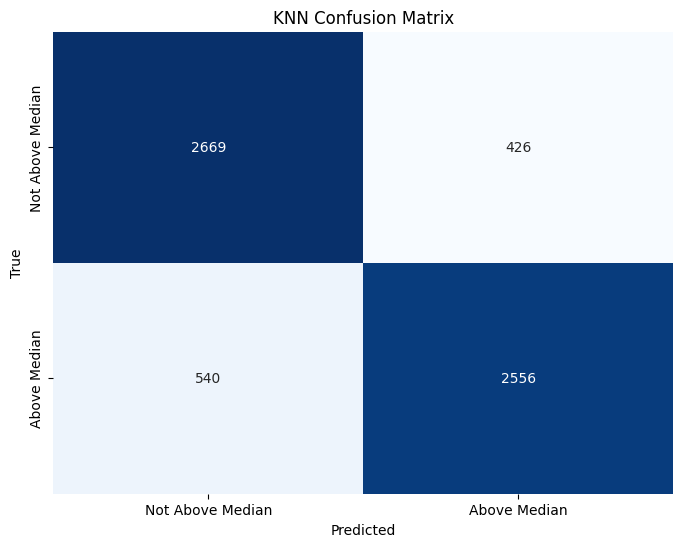

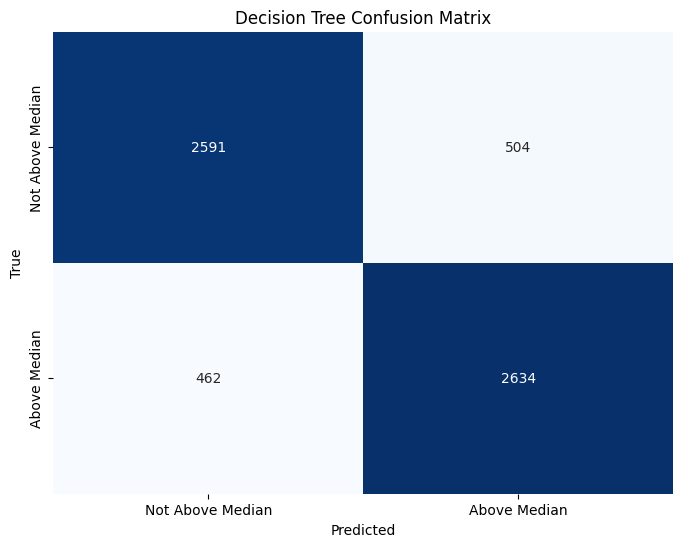

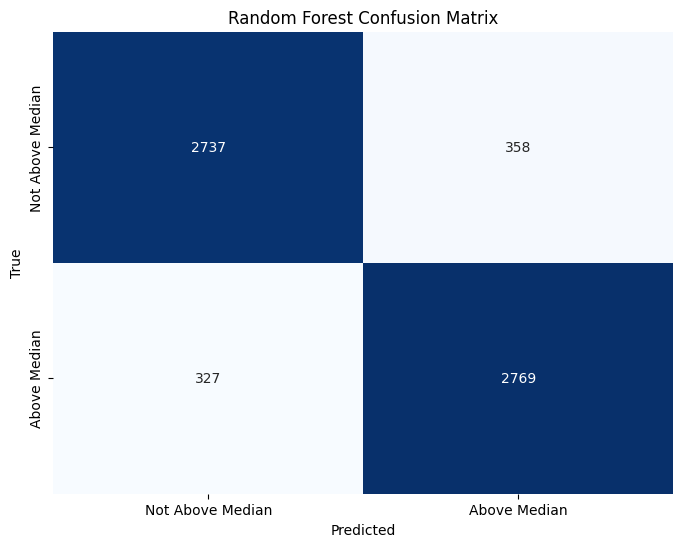

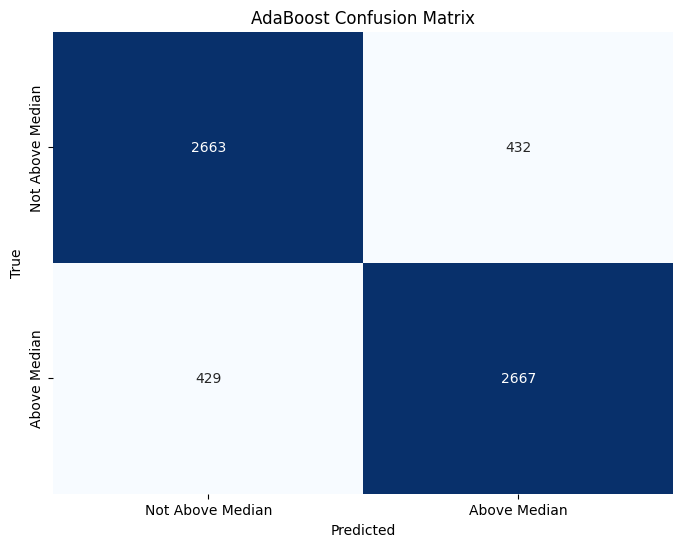

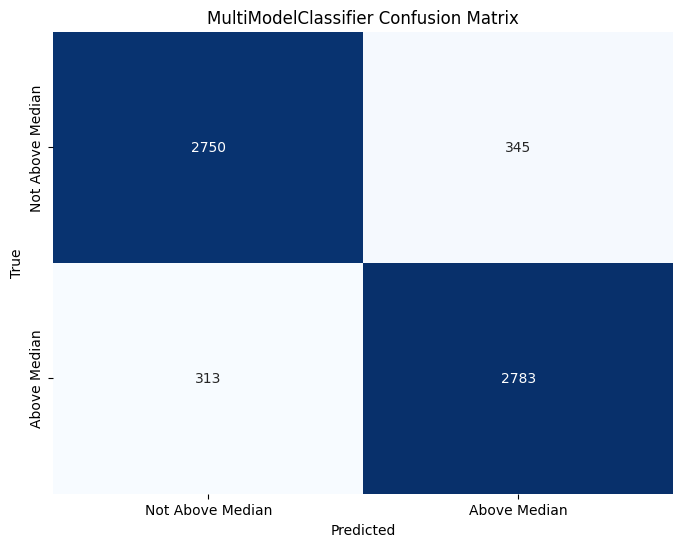

In [10]:
# Print confusion matrix for each model. (2 points)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Above Median', 'Above Median'],
                yticklabels=['Not Above Median', 'Above Median'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
# Plot confusion matrix for KNN, Decision Tree, Random Forest, and AdaBoost
plot_confusion_matrix(y_test, knn_y_test_pred, "KNN Confusion Matrix")
plot_confusion_matrix(y_test, dt_y_test_pred, "Decision Tree Confusion Matrix")
plot_confusion_matrix(y_test, rf_y_test_pred, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, ab_y_test_pred, "AdaBoost Confusion Matrix")
plot_confusion_matrix(y_test, mmc_y_test_pred, "MultiModelClassifier Confusion Matrix")